In [ ]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawChromosome


low, high = RawChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 3, 3, 1, 1, 6, 3]))

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import MlpNasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset


DatasetClass = VertebralDataset
params = MlpNasParams(
    epochs=10,
    patience=5,
    amount_of_evaluations=1,
    population_size=50,
    population_offspring_count=20,
    algorithm_generations=1,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(162.0, np.float64(2160.0))

In [4]:
plow = problem.get_nn_params(RawChromosome(low).parse())
phigh = problem.get_nn_params(RawChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(162.0, np.float64(2160.0))

In [5]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded successfully
DEBUG: Evaluating MLPParams(fc=FCParams(layers=[FCLayerParams(height=6, weight_qmode=<WeightQuantMode.NBITS: 'nbits'>, weight_bitwidth=6), FCLayerParams(height=3, weight_qmode=<WeightQuantMode.NONE: 'none'>, weight_bitwidth=32)], activation=ActivationParams(activation=<ActivationModule.TERNARIZE: 'ternary'>, binary_qmode=<QMode.DET: 'det'>, reste_o=np.int64(2), reste_threshold=1.5), qmode=<QMode.DET: 'det'>, dropout_rate=0.0), train=NNTrainParams(train_loader=<torch.utils.data.dataloader.DataLoader object at 0x7a48629786e0>, test_loader=<torch.utils.data.dataloader.DataLoader object at 0x7a486294c7d0>, epochs=10, learning_rate=0.002, weight_decay=0.001, early_stop_patience=5))
DEBUG: Train Epoch:  1 [  32/248] Loss: 1.1662
DEBUG: Train Epoch:  1 [ 192/248] Loss: 1.0261
DEBUG: Test set: Average loss: 1.8837, Accuracy: 24/62 (38.71%)
DEBUG: Train Epoch:  2 [  32/248] Loss: 1.0900
DEBUG: Train Epoch:  2 [ 192/248] Loss: 1.0970
DEBUG: Test set: Ave

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        5 |      2 |             - |             -
Solutions: [[2 0 7 4 8 3 8 2 0 1 3 0 1 6 0]
 [4 0 7 4 1 7 7 3 0 0 3 0 0 5 3]]
Objectives: [[-0.61290323  0.          0.        ]
 [-0.62903226  0.10718336  0.03571429]]


In [6]:
from dataclasses import asdict

from pprint import pprint
import pandas as pd
from pymoo.core.result import Result


def res_to_df(res: Result) -> pd.DataFrame:
    data = []
    for i in range(len(res.X)):
        x = res.X[i]
        f = res.F[i]
        accuracy = problem.denormalize(-f[0], 0, 100)
        complexity = problem.denormalize(
            f[1], problem.get_min_complexity(), problem.get_max_complexity()
        )

        ch = RawChromosome(x).parse()
        params = problem.get_nn_params(ch)

        data.append(
            {
                "Accuracy": accuracy,
                "Complexity": complexity,
                **asdict(params),
                "Chromosome": x,
            }
        )

    return pd.DataFrame(data)


df = res_to_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,61.290323,162.000000,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 46.4264, 6.6208...","[2, 0, 7, 4, 8, 3, 8, 2, 0, 1, 3, 0, 1, 6, 0]"
1,62.903226,376.152351,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 36.1257, 22.7588...","[4, 0, 7, 4, 1, 7, 7, 3, 0, 0, 3, 0, 0, 5, 3]"


In [7]:
ch = RawChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            weight_qmode=<WeightQuantMode.NBITS: 'nbits'>,
                                            weight_bitwidth=3),
                              FCLayerParams(height=3,
                                            weight_qmode=<WeightQuantMode.NONE: 'none'>,
                                            weight_bitwidth=32)],
                      activation=ActivationParams(activation=<ActivationModule.BINARIZE: 'binary'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                                                  reste_o=np.int64(3),
                                                  reste_threshold=1.5),
                      qmode=<QMode.DET: 'det'>,
                      dropout_rate=0.0),
          train=NNTrainParams(train_loader=<torch.utils.data.dataloader.DataLoader object at 0x7a48629786e0>,
                              test_loader=<torch.utils.da

DEBUG: matplotlib data path: /home/nur/Projects/vut-ip1-nn-quantization/venv/lib/python3.13/site-packages/matplotlib/mpl-data
DEBUG: CONFIGDIR=/home/nur/.config/matplotlib
DEBUG: interactive is False
DEBUG: platform is linux
DEBUG: CACHEDIR=/home/nur/.cache/matplotlib
DEBUG: Using fontManager instance from /home/nur/.cache/matplotlib/fontlist-v390.json
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/home/nur/Projects/vut-ip1-nn-quantization/venv/lib/python3.13/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG: findfont: score(FontEntry(fname='/home/nur/Projects/vut-ip1-nn-quantization/venv/l

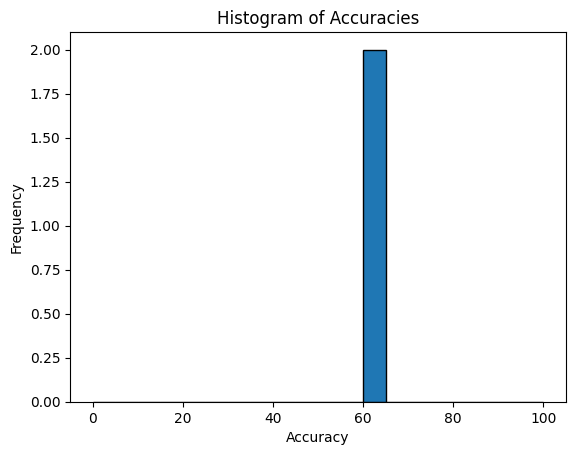

In [ ]:
from matplotlib import pyplot as plt


def hist_accuracies(accuracies: list[float], bins=20) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=bins, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies(df["Accuracy"])

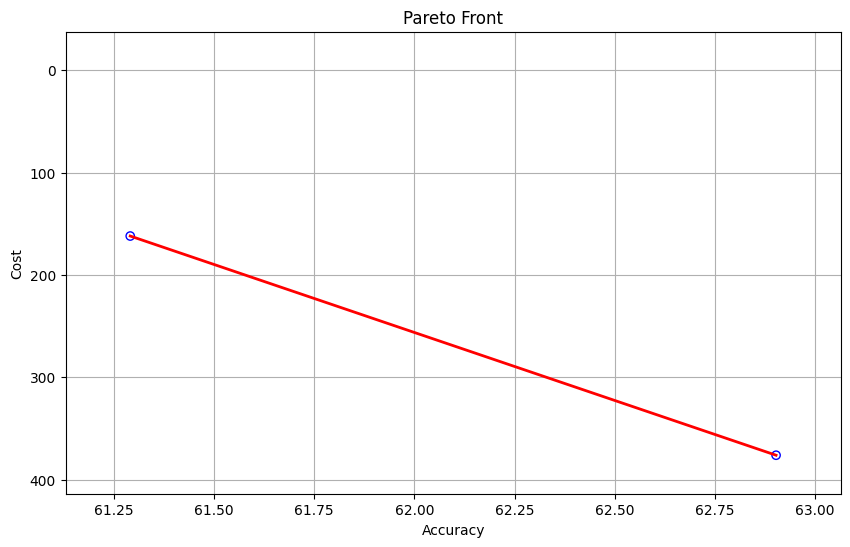

In [9]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])